# Masking MRS slices in each spectral band (based on DISTORTION CDP version 06.04.00)

One of the primary calibration data products (CDP) of the CALSPEC2 pipeline is the MRS DISTORTION CDP. This product contains information on the MRS integral-field-unit projected slices on the detector, along with the spatial and spectral distortion introduced by the optics. In this notebook we show how (/how well) the slice maps extension of the DISTORTION CDP represents the data. You can also think of this as a sanity check, where the slices should denote the 80% transmission cut-off of a flat source observed with the MRS. The 80% transmission value was used by Adrian Glauser to define the slice mask (see MIRI-TN-00001-ETH issue 2.1).

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

Let's check how well the DISTORTION CDP version 06.04.00 slice mask matches the 80% transmission criterion that defines the MRS FOV. We do this for a few datasets, including: 
* the MIRI Telescope Simulator (MTS) blackbody observations, taken at RAL during the MIRI flight model tests
* the MTS blackbody observations through a wave-pass filter
* the MIRI internal calibration source

In [1]:
import funcs
import mrsobs

import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [5]:
# Define paths to data
workDir   = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir    = workDir+'cdp_data/'
d2cMapDir = workDir+'notebooks/distortionMaps/'
lvl2path  = workDir+'FM_data/LVL2/'

In [7]:
sliceMap,sci_signal,sci_signal_swp,sci_signal_lwp,sci_signal_intcalsource = {},{},{},{},{}
for band in ['1A','1B','1C','2A','2B','2C','3A','3B','3C','4A','4B','4C']:
    # Load slice mask extension of distortion map
    sliceMap[band] = funcs.load_obj('d2cMaps_band{}_tr80pc'.format(band),path=d2cMapDir)['sliceMap']
    
    # Load fringe correction map and replace NaNs by 1
    fringe_img = funcs.get_cdps(band,cdpDir,output='img')[0]
    fringe_img[np.isnan(fringe_img)] = 1
    
    # Load extended source signal
    if band == '4C':
        source_signal,bkg_signal = mrsobs.FM_MTS_BB_extended_source(lvl2path,band,bb_temp='400K',output='img')
        sci_signal[band] = (source_signal-bkg_signal)/fringe_img
    else:
        source_signal,bkg_signal = mrsobs.FM_MTS_BB_extended_source(lvl2path,band,bb_temp='800K',output='img')
        sci_signal[band] = (source_signal-bkg_signal)/fringe_img
    
    source_signal,bkg_signal = mrsobs.FM_MTS_800K_BB_MRS_RAD_08(lvl2path,band,wp_filter='SWP',output='img')
    sci_signal_swp[band] = (source_signal-bkg_signal)/fringe_img
    
    source_signal,bkg_signal = mrsobs.FM_MTS_800K_BB_MRS_RAD_08(lvl2path,band,wp_filter='LWP',output='img')
    sci_signal_lwp[band] = (source_signal-bkg_signal)/fringe_img
    
    source_signal = mrsobs.MIRI_internal_calibration_source(lvl2path,band,campaign='FM',output='img')
    sci_signal_intcalsource[band] = source_signal/fringe_img

<IPython.core.display.Javascript object>


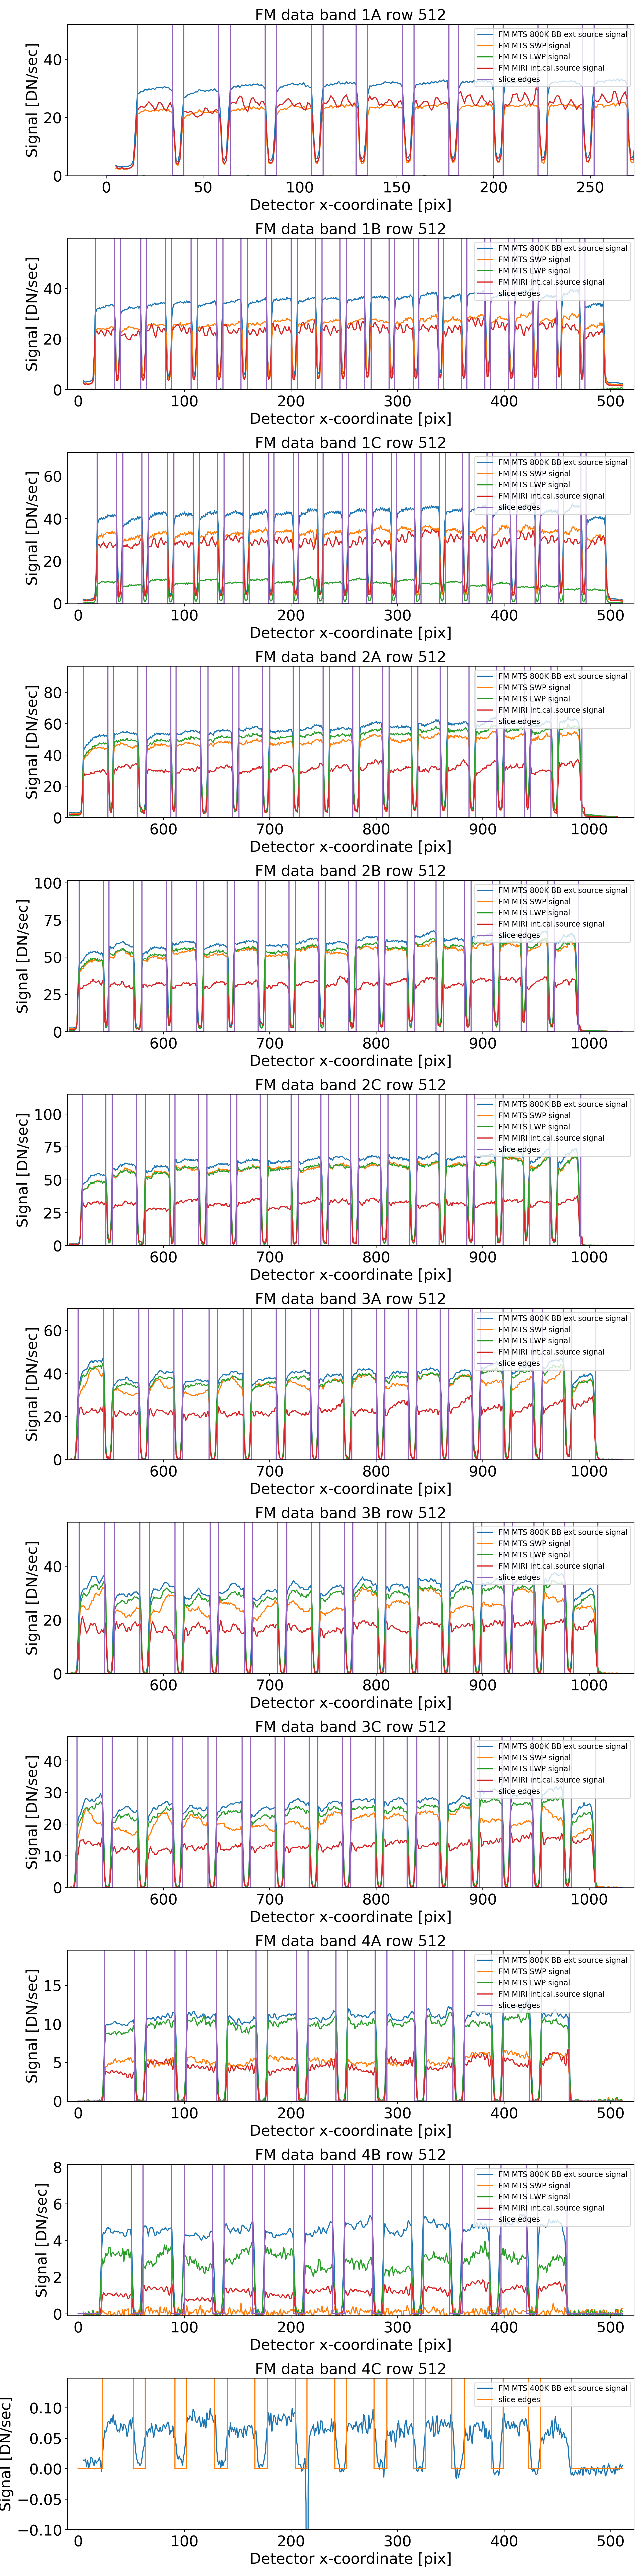

In [8]:
plt.close('all')
row = 100
fig,axs = plt.subplots(12,1,figsize=(12,48))
for plot,band in enumerate(['1A','1B','1C','2A','2B','2C','3A','3B','3C','4A','4B','4C']):
    axs[plot].set_title('FM data band {} row 512'.format(band),fontsize=20)
    if band[0] in ['1','4']:
        if band == '4C':
            axs[plot].plot(sci_signal[band][row,:512],label='FM MTS 400K BB ext source signal')
        else:
            axs[plot].plot(sci_signal[band][row,:512],label='FM MTS 800K BB ext source signal')
            axs[plot].plot(sci_signal_swp[band][row,:512],label='FM MTS SWP signal')
            axs[plot].plot(sci_signal_lwp[band][row,:512],label='FM MTS LWP signal')
            axs[plot].plot(sci_signal_intcalsource[band][row,:512]/30.,label='FM MIRI int.cal.source signal')
        axs[plot].step(np.arange(len(sliceMap[band][row,:512])),sliceMap[band][row,:512]*1000.,label='slice edges')
        axs[plot].set_ylim(-0.1,1.5*np.max(sci_signal[band][row,:512][~np.isnan(sci_signal[band][row,:512])]))
        axs[plot].set_xlim(-10,522)
    elif band[0] in ['2','3']:
        axs[plot].plot(512+np.arange(len(sci_signal[band][row,512:])),sci_signal[band][row,512:],label='FM MTS 800K BB ext source signal')
        axs[plot].plot(512+np.arange(len(sci_signal_swp[band][row,512:])),sci_signal_swp[band][row,512:],label='FM MTS SWP signal')
        axs[plot].plot(512+np.arange(len(sci_signal_lwp[band][row,512:])),sci_signal_lwp[band][row,512:],label='FM MTS LWP signal')
        axs[plot].plot(512+np.arange(len(sci_signal_intcalsource[band][row,512:])),sci_signal_intcalsource[band][row,512:]/30.,label='FM MIRI int.cal.source signal')
        axs[plot].step(512+np.arange(len(sliceMap[band][row,512:])),sliceMap[band][row,512:]*1000.,label='slice edges')
        axs[plot].set_ylim(-0.1,1.5*np.max(sci_signal[band][row,512:][~np.isnan(sci_signal[band][row,512:])]))
        axs[plot].set_xlim(510,1042)
    axs[plot].set_xlabel('Detector x-coordinate [pix]',fontsize=20)
    axs[plot].set_ylabel('Signal [DN/sec]',fontsize=20)
    axs[plot].legend(loc='upper right',fontsize=10)
    axs[plot].tick_params(axis='both',labelsize=20)
plt.tight_layout()

### Remarks:
* For all datasets, qualitatively speaking, the slice mask does not match the 80% transmission criterion. The slice mask is thus found to not follow the physical slices.
  
Let us check the above issue for different blackbody temperatures (same conclusion expected, but just as a sanity check).

In [5]:
# check for any discrepancies between different extended BB temperatures
sliceMap,sci_signal_800K,sci_signal_600K,sci_signal_400K = {},{},{},{}
for band in ['1A','1B','1C','2A','2B','2C','3A','3B','3C','4A','4B','4C']:
    # Load slice mask extension of distortion map
    sliceMap[band] = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)['sliceMap']
    
    # Load fringe correction map and replace NaNs by 1
    fringe_img = funcs.get_cdps(band,cdpDir,output='img')[0]
    fringe_img[np.isnan(fringe_img)] = 1
    
    # Load extended source signal
    source_signal,bkg_signal = mrsobs.FM_MTS_BB_extended_source(lvl2path,band,bb_temp='800K',output='img')
    sci_signal_800K[band] = (source_signal-bkg_signal)/fringe_img
    
    source_signal,bkg_signal = mrsobs.FM_MTS_BB_extended_source(lvl2path,band,bb_temp='600K',output='img')
    sci_signal_600K[band] = (source_signal-bkg_signal)/fringe_img
    
    source_signal,bkg_signal = mrsobs.FM_MTS_BB_extended_source(lvl2path,band,bb_temp='400K',output='img')
    sci_signal_400K[band] = (source_signal-bkg_signal)/fringe_img

<IPython.core.display.Javascript object>


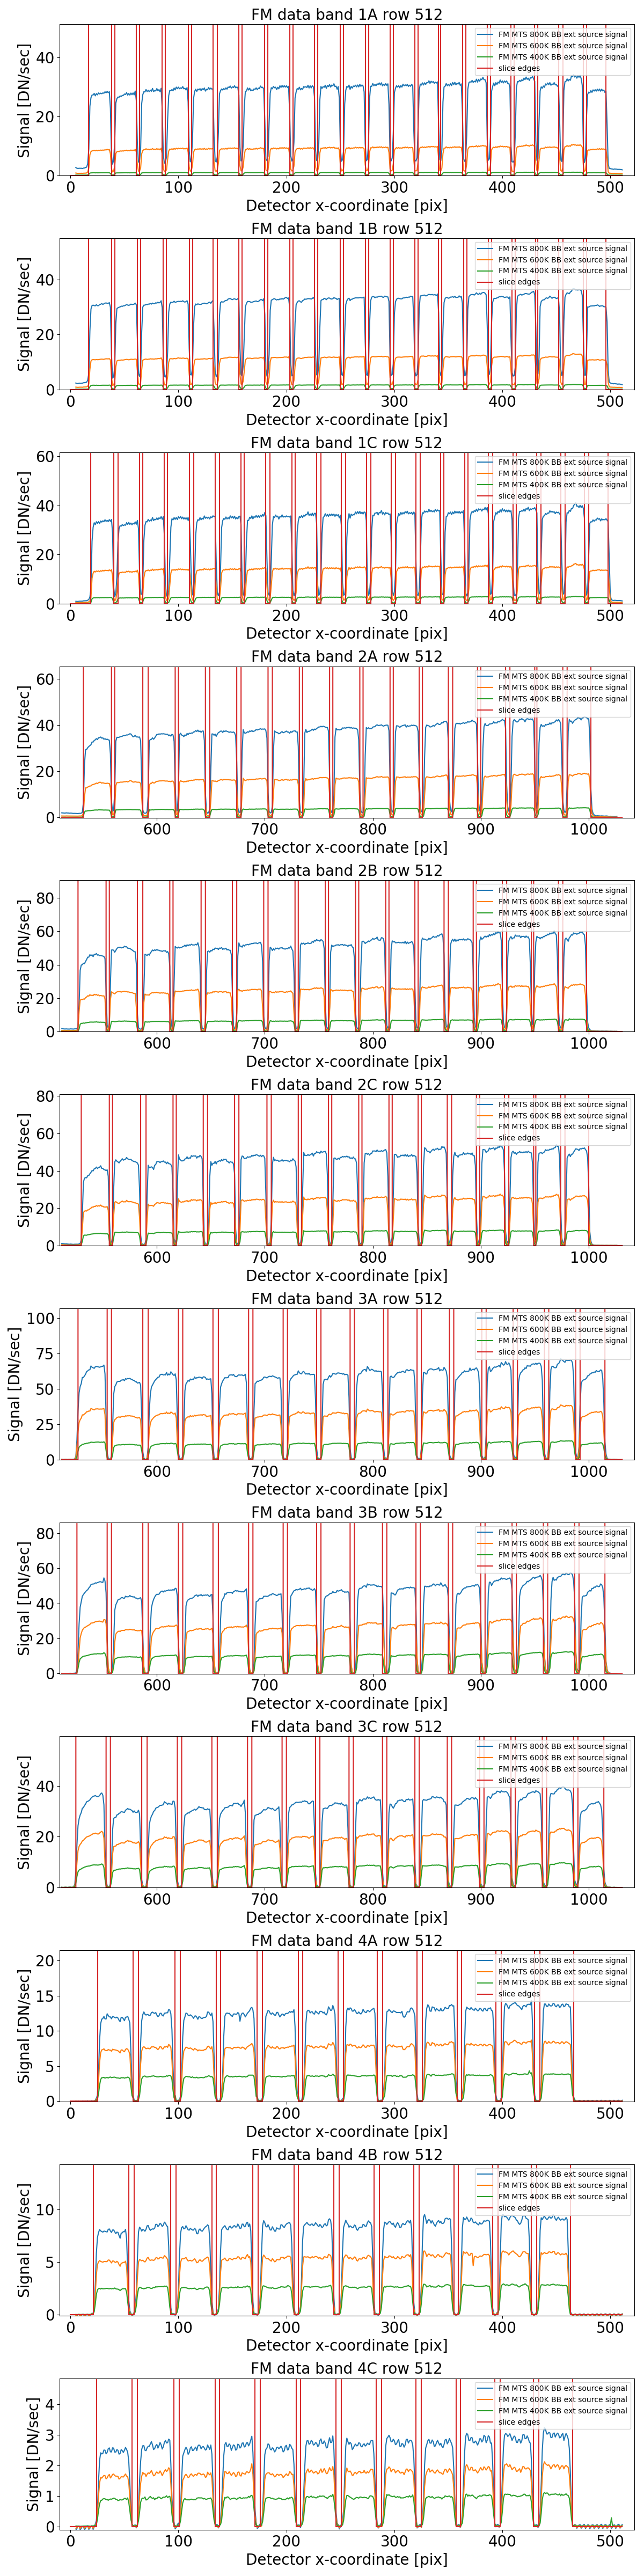

In [6]:
plt.close('all')
row = 512
fig,axs = plt.subplots(12,1,figsize=(12,48))
for plot,band in enumerate(['1A','1B','1C','2A','2B','2C','3A','3B','3C','4A','4B','4C']):
    axs[plot].set_title('FM data band {} row 512'.format(band),fontsize=20)
    if band[0] in ['1','4']:
        axs[plot].plot(sci_signal_800K[band][row,:512],label='FM MTS 800K BB ext source signal')
        axs[plot].plot(sci_signal_600K[band][row,:512],label='FM MTS 600K BB ext source signal')
        axs[plot].plot(sci_signal_400K[band][row,:512],label='FM MTS 400K BB ext source signal')
        axs[plot].step(np.arange(len(sliceMap[band][row,:512])),sliceMap[band][row,:512]*1000.,label='slice edges')
        axs[plot].set_ylim(-0.1,1.5*np.max(sci_signal_800K[band][row,:512][~np.isnan(sci_signal_800K[band][row,:512])]))
        axs[plot].set_xlim(-10,522)
    elif band[0] in ['2','3']:
        axs[plot].plot(512+np.arange(len(sci_signal_800K[band][row,512:])),sci_signal_800K[band][row,512:],label='FM MTS 800K BB ext source signal')
        axs[plot].plot(512+np.arange(len(sci_signal_600K[band][row,512:])),sci_signal_600K[band][row,512:],label='FM MTS 600K BB ext source signal')
        axs[plot].plot(512+np.arange(len(sci_signal_400K[band][row,512:])),sci_signal_400K[band][row,512:],label='FM MTS 400K BB ext source signal')
        axs[plot].step(512+np.arange(len(sliceMap[band][row,512:])),sliceMap[band][row,512:]*1000.,label='slice edges')
        axs[plot].set_ylim(-0.1,1.5*np.max(sci_signal_800K[band][row,512:][~np.isnan(sci_signal_800K[band][row,512:])]))
        axs[plot].set_xlim(510,1042)
    axs[plot].set_xlabel('Detector x-coordinate [pix]',fontsize=20)
    axs[plot].set_ylabel('Signal [DN/sec]',fontsize=20)
    axs[plot].legend(loc='upper right',fontsize=10)
    axs[plot].tick_params(axis='both',labelsize=20)
plt.tight_layout()

### Remarks:
* The three blackbody temperatures show the same discrepancy with the slice mask of DISTORTION CDP version 06.04.00.
  
An interesting point is that, given that sub-channels A, B, C are observed with different diffraction gratings (positioned at different angles), the position of the slices may not necessarily match between sub-channels. We show this below.

<IPython.core.display.Javascript object>


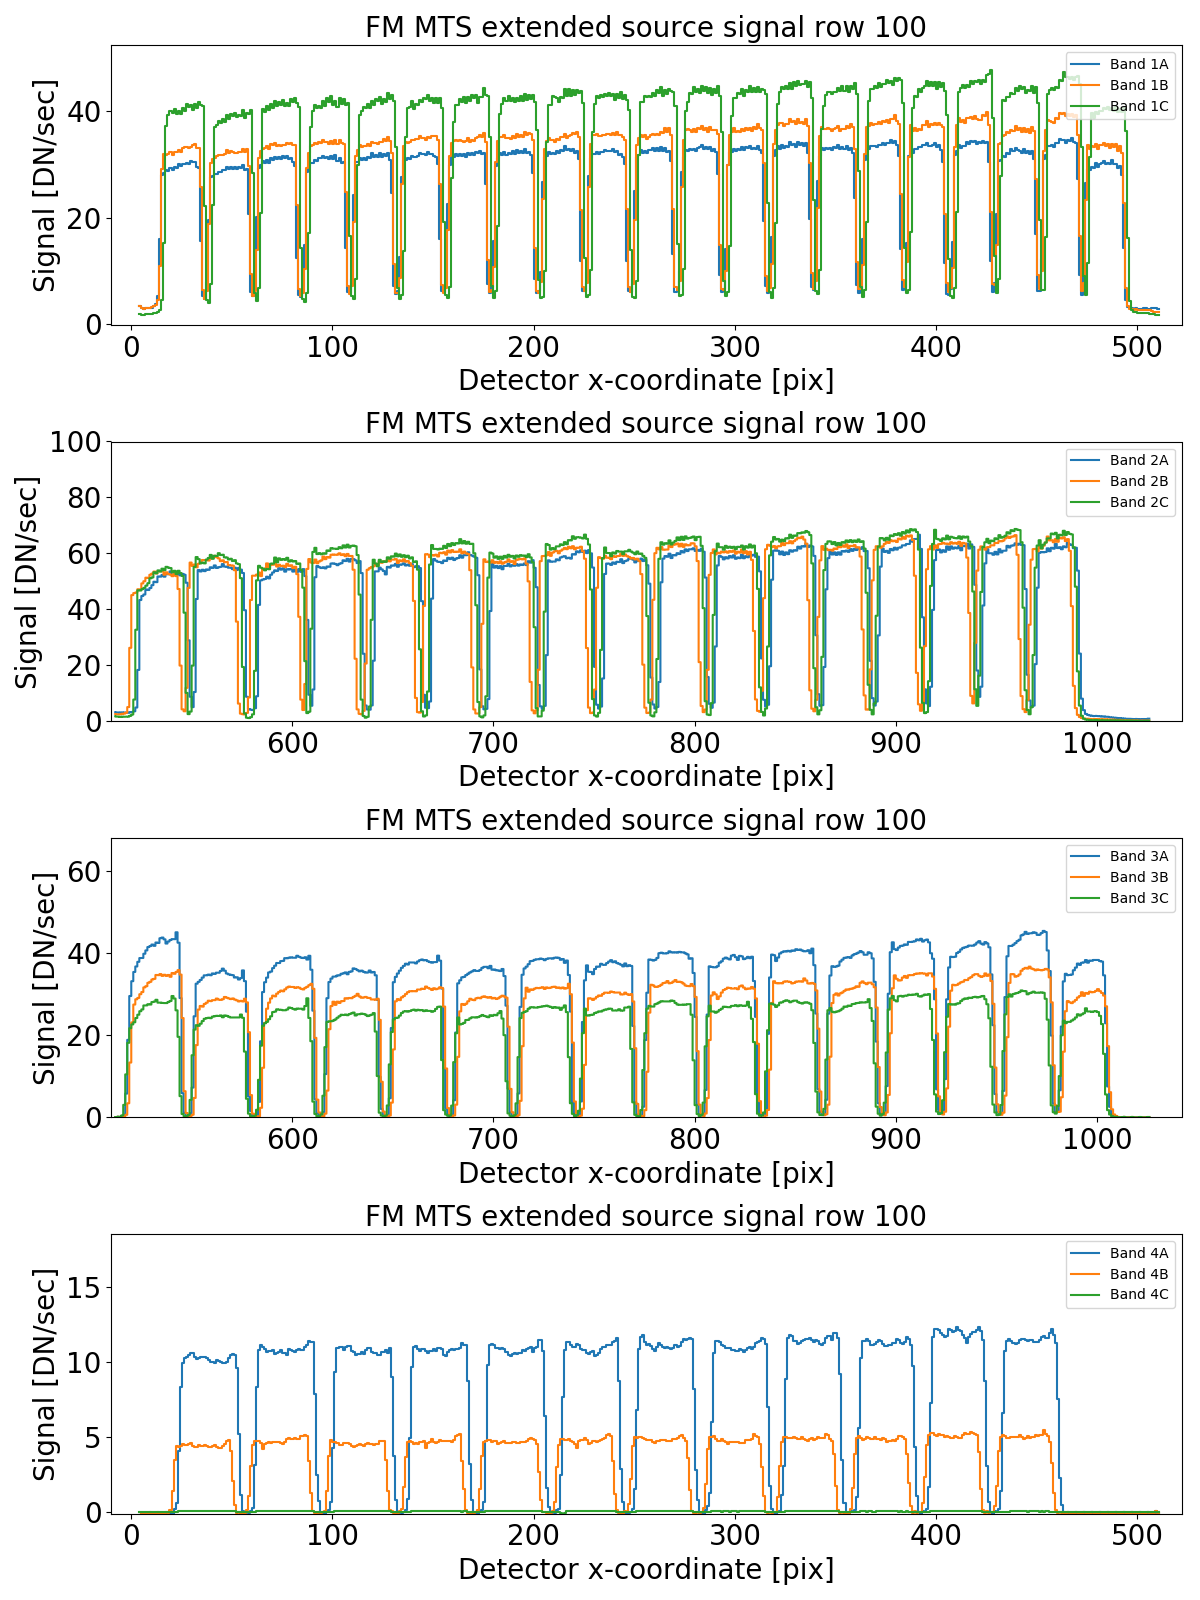

In [13]:
# just as a sanity check, the slice mask in different sub-channels (A,B,C) of a given channel (1,2,3,4) do not necessarily overlap
plt.close('all')
row = 100
fig,axs = plt.subplots(4,1,figsize=(12,16))
for band in ['1A','1B','1C']:
    axs[0].step(np.arange(len(sci_signal[band][row,:512])),sci_signal[band][row,:512],label='Band {}'.format(band))
# axs[0].step(np.arange(len(sliceMap['1A'][row,:512])),sliceMap['1A'][row,:512]*1000.,label='slice edges')
axs[0].set_ylim(-0.1,1.5*np.max(sci_signal['1A'][row,:512][~np.isnan(sci_signal['1A'][row,:512])]))
axs[0].set_xlim(-10,522)
for band in ['2A','2B','2C']:
    axs[1].step(512+np.arange(len(sci_signal[band][row,512:])),sci_signal[band][row,512:],label='Band {}'.format(band))
# axs[1].step(512+np.arange(len(sliceMap['2A'][row,512:])),sliceMap['2A'][row,512:]*1000.,label='slice edges')
axs[1].set_ylim(-0.1,1.5*np.max(sci_signal['2A'][row,512:][~np.isnan(sci_signal['2A'][row,512:])]))
axs[1].set_xlim(510,1042)
for band in ['3A','3B','3C']:
    axs[2].step(512+np.arange(len(sci_signal[band][row,512:])),sci_signal[band][row,512:],label='Band {}'.format(band))
# axs[2].step(512+np.arange(len(sliceMap['3A'][row,512:])),sliceMap['3A'][row,512:]*1000.,label='slice edges')
axs[2].set_ylim(-0.1,1.5*np.max(sci_signal['3A'][row,512:][~np.isnan(sci_signal['3A'][row,512:])]))
axs[2].set_xlim(510,1042)
for band in ['4A','4B','4C']:
    axs[3].step(np.arange(len(sci_signal[band][row,:512])),sci_signal[band][row,:512],label='Band {}'.format(band))
# axs[3].step(np.arange(len(sliceMap['4A'][row,:512])),sliceMap['4A'][row,:512]*1000.,label='slice edges')
# axs[3].step(np.arange(len(sliceMap['4B'][row,:512])),sliceMap['4B'][row,:512]*1000.,label='slice edges')
axs[3].set_ylim(-0.1,1.5*np.max(sci_signal['4A'][row,:512][~np.isnan(sci_signal['4A'][row,:512])]))
axs[3].set_xlim(-10,522)
for plot in range(4):
    axs[plot].set_title('FM MTS extended source signal row {}'.format(row),fontsize=20)
    axs[plot].set_xlabel('Detector x-coordinate [pix]',fontsize=20)
    axs[plot].set_ylabel('Signal [DN/sec]',fontsize=20)
    axs[plot].legend(loc='upper right',fontsize=10)
    axs[plot].tick_params(axis='both',labelsize=20)
plt.tight_layout()